In [ ]:
import torch
from torch.utils.data import Dataset ,random_split
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_b0
import torchvision as transforms
from torchvision.datasets import ImageFolder

In [1]:
from torchvision.datasets import FakeData

In [10]:
import kagglehub

C:\Users\polur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import torch
from torch.autograd import grad
import torch.nn.functional as F
import torch.nn as nn
import pickle

In [5]:
torch.manual_seed(38)

Определяем преобразования для картинок

In [ ]:
from torchvision.transforms import v2
transform = v2.Compose([
    v2.PILToTensor(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True), 
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
])
dataset=ImageFolder("data/Mushrooms/Mushrooms",transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.151983].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1868412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2885156].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.323529

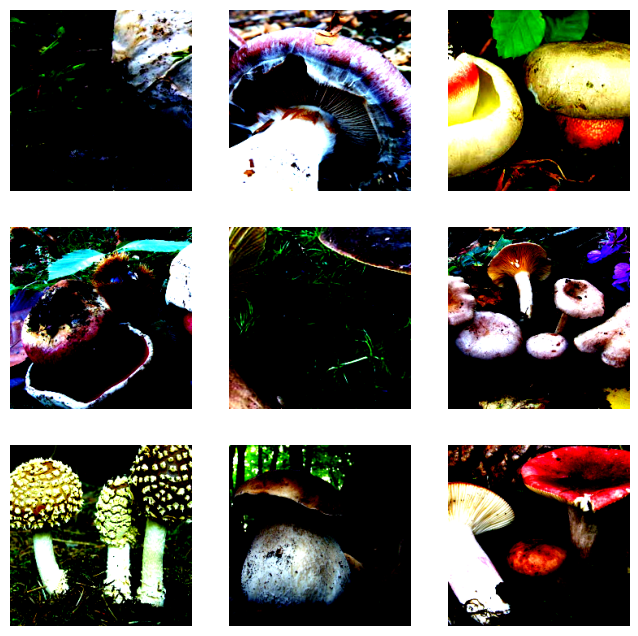

In [92]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()



Получаем вот такие картинки

In [93]:
img, label =dataset[0]
type(img)

torch.Tensor

In [114]:
len(dataset)

6714

In [113]:
train_size=int(len(dataset)*0.9)
test_size=len(dataset)-train_size

Делим на данные для обучения и валидации

In [126]:
train_data, test_data=random_split(dataset,[train_size,test_size],generator=torch.manual_seed(38))

In [ ]:
train_dataloader= torch.utils.data.DataLoader(
    train_data, batch_size=512, shuffle =True, num_workers=0)
#cutmix = v2.CutMix(num_classes=9)
#mixup = v2.MixUp(num_classes=9)
#cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])   #Попытался сделать аугментацию, не получилось(
test_dataloader =torch.utils.data.DataLoader(
    test_data,batch_size=512,shuffle=False,num_workers=0)


In [20]:
from torch import optim
from tqdm import tqdm

In [103]:
# define a train function, model-agnostic, which will be used for further training
def train(net, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.RAdam(net.parameters(), lr=learning_rate)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []
    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:
        for param in net.parameters():
            param.requires_grad = False
        for param in net.classifier.parameters():
            param.requires_grad = True
        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 

            for batch_num, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                # Backpropagation                
                loss.backward()

                # Update
                optimizer.step()

                # Print progress
                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total

                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct
            # Print the evaluation metric and reset it for the next epoch
            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history



Скачиваем предобученную модель и работаем только со слоем классификации

In [ ]:
net=efficientnet_b0(weights='DEFAULT') 

In [85]:
net.classifier = nn.Sequential(
  torch.nn.Flatten(),
  torch.nn.Linear(1280, 4096),
  torch.nn.ReLU(),
  torch.nn.Dropout(0.5),
  torch.nn.Linear(4096, 4096),
  torch.nn.ReLU(),
  torch.nn.Dropout(0.5),
  torch.nn.Linear(4096, 9)
)

In [86]:
for param in net.parameters():
    param.requires_grad = False
for param in net.classifier.parameters():
    param.requires_grad = True

In [104]:
# prepare training
BATCH_SIZE = 512
EPOCHS = 30
LR = 0.001
device='cpu'

hist = train(net, train_dataloader, device, EPOCHS, LR)
torch.save(net.state_dict(),'my_model.pth')#сохранение весов

Epoch: 29, Batch: 11, Loss: 6.33, Acc: 0.78: 100%|██████████| 360/360 [37:35<00:00,  6.27s/it]


In [75]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

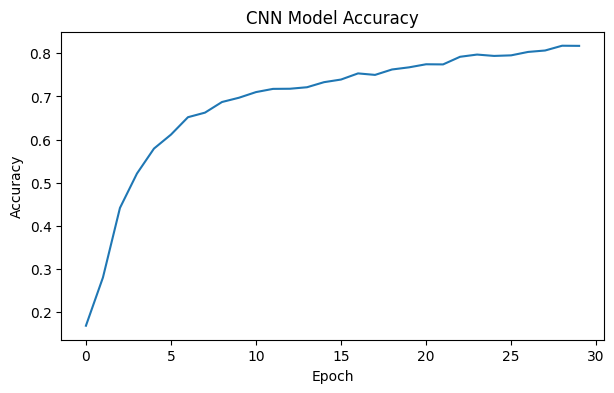

In [108]:
print_history(hist, "СNN Model Accuracy")

In [130]:
def evaluate_acc(net, test_loader, device='cpu'):

    total = 0
    correct = 0
    
    for batch_num, (inputs, labels) in enumerate(test_loader):
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)        
        _, predicted = outputs.max(1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    acc = correct/total
    return acc


In [131]:
net.load_state_dict(torch.load("my_model.pth")) #загрузка весов
acc=evaluate_acc(net,test_dataloader)


In [132]:
acc

0.8080357142857143

Результат достигнут

Что ещё было сделано:
    Изначально пытался обучить AlexNet после 3ёх часов обучения на gpu в гугл колаб результат был 0.4, что весьма неутешительно,
    путём изменения предобработки картинок максимально получилось достигнуть 0.5, поэтому решил использовать предобученную модель с заморозкой и другим методом оптимизации